In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

2025-10-16 07:14:51.383678: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 07:14:51.514297: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-16 07:14:51.514340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-16 07:14:51.531242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-16 07:14:51.569859: I tensorflow/core/platform/cpu_feature_guar

## Load in z=0 quijote LR snapshot 663

In [2]:
idx_LH_str = '0663'
sim_name_quijote = f'quijote_LH{idx_LH_str}'

#dir_data = '/cosmos_storage/home/mpelle/Yin_data/Quijote'
dir_mocks = '/scratch/kstoreyf/Yin_data/Quijote' #hyp
fn_params = f'{dir_mocks}/LH{idx_LH_str}/param_{idx_LH_str}.txt'
param_vals = np.loadtxt(fn_params)
param_names = ['omega_m', 'omega_baryon', 'h', 'n_s', 'sigma_8']
param_dict = dict(zip(param_names, param_vals))
param_dict['tau'] = 0.0952 # ?? TODO check proper tau to be using!! 
cosmo_quijote = utils.get_cosmo(param_dict)

In [3]:
import readgadget

idx_LH = '663'
#snapshot = '/dipc/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/663/snapdir_004/snap_004' # 004 = z0 #atlas248
snapshot = f'/scratch/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/{idx_LH}/snapdir_004/snap_004' # 004 = z0 #hyperion
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

In [ ]:
# read positions, velocities and IDs of the particles
pos_snap = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
vel_snap = readgadget.read_block(snapshot, "VEL ", ptype)
print(pos_snap.shape, vel_snap.shape)
ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

(134217728, 3) (134217728, 3)


: 

In [ ]:
# ics
snapshot_ics = '/scratch/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/663/ICs/ics'
ids_ics = readgadget.read_block(snapshot_ics, "ID  ", ptype)-1   #IDs starting from 0

In [ ]:

fn_lag_index = f'/scratch/kstoreyf/Quijote_simulations/quijote_LH{idx_LH}_neighfile.pickle'
with open(fn_lag_index, 'rb') as f:
    lag_index = pickle.load(f)
print(lag_index.shape)

In [ ]:
pos_snap_ord = pos_snap[lag_index]
vel_snap_ord = vel_snap[lag_index]

## Check velocity smoothing

### compute bispec

In [ ]:
# trying this
n_grid = 512
box_size = 1000.
mesh = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_snap, 
                                     vel=None, mass=None,
                 interlacing=False, deposit_method='cic',
                 zspace=False, cosmology=None)
print(mesh.shape)

2025-07-02 08:49:40,447 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2025-07-02 08:49:40,448 bacco.statistics : starting deposit 1
2025-07-02 08:49:47,029 bacco.statistics :  mesh done in 6.58 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
(1, 512, 512, 512)


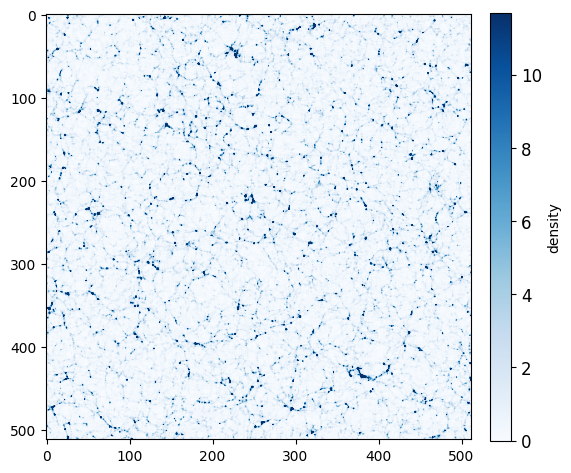

In [ ]:
plotter.plot_field(mesh[0], overdensity=False)

In [ ]:
import compute_statistics as cs
# compute bispectrum
n_threads = 8
base = cs.setup_bispsec(box_size, n_grid, n_threads)
bspec, bk_corr = cs.compute_bispectrum(base, mesh)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [512, 512, 512]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [1.608, 1.608, 1.608] h/Mpc
# Pixel window: none


: 

In [ ]:
# need to un-normalize bc the field was already normalized, and the 
# bispec code is doing extra normalization
norm = n_grid**3
weight = k123.prod(axis=0)

# cube the norm because it's the bispectrum
plt.plot(norm**3 * weight*bk_corr['b0'],c='k')
    #plt.plot(weight*bk_uncorr['b%d'%l],c=cs[l//2],ls='--')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)

### back to pk

In [ ]:
def fv2bro(t_fv_field) :
    '''Returns back row ordered array (shape n_grid * n_grid * n_grid, 3) from front vector (shape 3, n_grid, n_grid, n_grid)'''
    return np.reshape(t_fv_field, (3, int(t_fv_field.size / 3))).T

In [ ]:
def bro2fv(t_bro_field):
    '''Returns front vector ordered array (shape 3, n_grid, n_grid, n_grid) from back row (shape n_grid * n_grid * n_grid, 3)'''
    n_grid = int(np.cbrt(t_bro_field.shape[0]))
    t_bro_field_copy = t_bro_field.copy()
    t_bro_field_copy = t_bro_field_copy.reshape(n_grid, n_grid, n_grid, 3, order='C')
    t_bro_field_copy = t_bro_field_copy.transpose(3,0,1,2)
    return t_bro_field_copy

In [ ]:
subdir_prefix='LH'

fn_disp = f'{dir_mocks}/{subdir_prefix}{idx_LH_str}/dis_{idx_LH_str}.npy'
fn_vel_sim = f'{dir_mocks}/{subdir_prefix}{idx_LH_str}/nlvel_{idx_LH_str}.npy'
#fn_vel_pred = f'{dir_mocks}/{subdir_prefix}{idx_LH_str}/pred_vel_{idx_LH_str}.npy'

disp = np.load(fn_disp)
vel_sim = np.load(fn_vel_sim)
velocities = fv2bro(vel_sim.copy(order='C'))
print(vel_sim.shape, velocities.shape)


In [ ]:
n_grid = 512
box_size = 1000.
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

#print("Adding predicted displacements")
pos = bacco.scaler.add_displacement(None,
                                    disp,
                                    box=box_size,
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=False)[0]
print(disp.shape, pos.shape)

In [ ]:
n_grid = 512
# vel_snap_ord_copy = vel_snap_ord.copy()
# vel_snap_grid = vel_snap_ord_copy.reshape(n_grid, n_grid, n_grid, 3, order='C')
# vel_snap_grid = vel_snap_grid.transpose(3,0,1,2)
vel_snap_grid = bro2fv(vel_snap_ord)
vel_snap_mag = np.linalg.norm(vel_snap_grid, axis=0)
print(vel_snap_mag.shape)

In [ ]:
plotter.plot_field(vel_snap_mag, title=r'velocity field (simulation particles)',
                label_cbar='velocity', overdensity=False
                )

In [ ]:
vel_sim_mag = np.linalg.norm(vel_sim, axis=0)

In [ ]:
plotter.plot_field(vel_sim_mag, title=r'velocity field via halos',
                label_cbar='velocity', overdensity=False
                )

In [ ]:
plotter.plot_field(vel_sim_mag-vel_snap_mag, title=r'diff between NL vel and sim vel',
                label_cbar='Delta velocity', overdensity=True
                )

In [ ]:
from scipy.ndimage import gaussian_filter
# Calculate sigma in grid units

def smooth_velocities(vel_arr, smoothing_scale):
    sigma = smoothing_scale / (box_size / n_grid)
    vel_arr_smoothed = np.zeros_like(vel_arr)

    # Apply Gaussian filter to each velocity component
    for i in range(3):
        vel_arr_smoothed[i] = gaussian_filter(
            vel_arr[i], sigma=sigma, mode='wrap'
        )
    return vel_arr_smoothed 

In [ ]:
vel_snap_grid_smoothedtiny = smooth_velocities(vel_snap_grid, smoothing_scale=0.001)

In [ ]:
vel_snap_mag_smoothedtiny = np.linalg.norm(vel_snap_grid_smoothedtiny, axis=0)
vel_snap_ord_smoothedtiny = fv2bro(vel_snap_grid_smoothedtiny)
plotter.plot_field(vel_snap_mag_smoothedtiny, title=r'velocity field, smoothed (0.001 Mpc/h)',
                label_cbar='velocity', overdensity=False
                )

In [ ]:
vel_snap_grid_smoothed2 = smooth_velocities(vel_snap_grid, smoothing_scale=2)

In [ ]:
vel_snap_mag_smoothed2 = np.linalg.norm(vel_snap_grid_smoothed2, axis=0)
vel_snap_ord_smoothed2 = fv2bro(vel_snap_grid_smoothed2)
plotter.plot_field(vel_snap_mag_smoothed2, title=r'velocity field, smoothed (2 Mpc/h)',
                label_cbar='velocity', overdensity=False
                )

In [ ]:
vel_snap_grid_smoothed4 = smooth_velocities(vel_snap_grid, smoothing_scale=4)

In [ ]:
vel_snap_mag_smoothed4 = np.linalg.norm(vel_snap_grid_smoothed4, axis=0)
vel_snap_ord_smoothed4 = fv2bro(vel_snap_grid_smoothed4)
plotter.plot_field(vel_snap_mag_smoothed4, title=r'velocity field, smoothed (4 Mpc/h)',
                label_cbar='velocity', overdensity=False
                )

In [ ]:
vel_snap_grid_smoothed8 = smooth_velocities(vel_snap_grid, smoothing_scale=8)

In [ ]:
vel_snap_mag_smoothed8 = np.linalg.norm(vel_snap_grid_smoothed8, axis=0)
vel_snap_ord_smoothed8 = fv2bro(vel_snap_grid_smoothed8)
plotter.plot_field(vel_snap_mag_smoothed8, title=r'velocity field, smoothed (8 Mpc/h)',
                label_cbar='velocity', overdensity=False
                )

In [ ]:
vel_snap_grid_smoothedbig = smooth_velocities(vel_snap_grid, smoothing_scale=32)

In [ ]:
vel_snap_mag_smoothedbig = np.linalg.norm(vel_snap_grid_smoothedbig, axis=0)
vel_snap_ord_smoothedbig = fv2bro(vel_snap_grid_smoothedbig)
plotter.plot_field(vel_snap_mag_smoothedbig, title=r'velocity field, smoothed (32 Mpc/h)',
                label_cbar='velocity', overdensity=False
                )

In [ ]:
k_min = 0.01
k_max = 1.0
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = True

# defaults from bacco.statistics.compute_power
# unless passed or otherwise denoted
args_power = {
    "ngrid": n_grid,
    "box": box_size,
    #"pos": None,
    #"vel": None,
    "mass": None,
    "interlacing": interlacing, #default: None
    "unit_in_Mpc": 1,
    "deposit_method": deposit_method, # default: 'cic',
    "bs_method": None,
    "bs_num_triangles": 10000,
    "bs_k1": 0.01,
    "bs_k2": None,
    "bs_deltak": None,
    "log_binning": log_binning,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid, #default: True,
    "deconvolve_grid": deconvolve_grid, #default: True,
    "normalise_grid": normalise_grid, #default: True,
    "totalmass": None,
    "correct_shotnoise": False,
    #"zspace": False,
    "cosmology": cosmo_quijote,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "grid1": None,
    "dilution": None,
    "folds": None,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "jack_error": False,
    "n_jack": None
}

# defaults from bacco.statistics.compute_crossspectrum_twogrids
# unless passed or otherwise denoted
args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    "ngrid": n_grid,
    "box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    #"zspace": False,
    "cosmology": cosmo_quijote,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

pknbody_dict = {
    'ngrid': n_grid,
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid}})


In [ ]:
pk_obj_real = bacco.statistics.compute_powerspectrum(
    pos=pos_snap,
    vel=None,
    zspace=False,
    **args_power
)

In [ ]:
pk_obj_zspace = bacco.statistics.compute_powerspectrum(
    pos=pos_snap,
    vel=vel_snap,
    zspace=True,
    **args_power
)

In [ ]:
pk_obj_zspace_smoothed2 = bacco.statistics.compute_powerspectrum(
    pos=pos_snap_ord,
    vel=vel_snap_ord_smoothed2,
    zspace=True,
    **args_power
)

In [ ]:
pk_obj_zspace_smoothed4 = bacco.statistics.compute_powerspectrum(
    pos=pos_snap_ord,
    vel=vel_snap_ord_smoothed4,
    zspace=True,
    **args_power
)

In [ ]:
pk_obj_zspace_smoothed8 = bacco.statistics.compute_powerspectrum(
    pos=pos_snap_ord,
    vel=vel_snap_ord_smoothed8,
    zspace=True,
    **args_power
)

In [ ]:
pk_obj_zspace_smoothedtiny = bacco.statistics.compute_powerspectrum(
    pos=pos_snap_ord,
    vel=vel_snap_ord_smoothedtiny,
    zspace=True,
    **args_power
)

In [ ]:
pk_obj_zspace_smoothedbig = bacco.statistics.compute_powerspectrum(
    pos=pos_snap_ord,
    vel=vel_snap_ord_smoothedbig,
    zspace=True,
    **args_power
)

In [ ]:
pk_obj_zspace_nlvel = bacco.statistics.compute_powerspectrum(
    pos=pos,
    vel=velocities,
    zspace=True,
    **args_power
)

In [ ]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr
alpha = 0.8

labels = [r'real space',
          r'redshift space, from sim particles)',
          r'redshift space (smoothed, 0.001 Mpc/h)',
          r'redshift space (smoothed, 2 Mpc/h)',
          r'redshift space (smoothed, 4 Mpc/h)',
          r'redshift space (smoothed, 8 Mpc/h)',
          r'redshift space (smoothed, 32 Mpc/h)',
          r'redshift space (via halos)',
          ]
colors = ['blue', 'magenta', 'grey', 'yellow', 'orange', 'red', 'brown', 'green']
lss = [':', '-', '--', '--', '--', '--', '--', '-.']
lws = [2, 2, 1, 1.5, 1.5, 1.5, 1, 2]
pk_objs = [pk_obj_real,
           pk_obj_zspace,
           pk_obj_zspace_smoothedtiny,
           pk_obj_zspace_smoothed2,
           pk_obj_zspace_smoothed4,
           pk_obj_zspace_smoothed8,
           pk_obj_zspace_smoothedbig,
           pk_obj_zspace_nlvel,
           ]
zorders = list(range(len(pk_objs),0,-1))
zorders[2] = 100
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
#errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)
plt.suptitle(f'Quijote LH {idx_LH_str}', fontsize=16)

#ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=3)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], lw=lws[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    
    ax1.plot(ks[i], (pks[i]-pk_obj_zspace['pk'])/pk_obj_zspace['pk'], ls=lss[i], label=labels[i], 
              lw=lws[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    # if len(pk_emu)!=len(pks[i]):
    #     pk_interp = np.interp(kk, ks[i], pks[i])
    #     err_interp = np.interp(kk, ks[i], errs[i])
    #     ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    #     ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    # else:
    #     ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    #     ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


ax1.axhline(0.0, color='grey')

axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P(k)-P_\text{simpart}(k))/P_\text{simpart}(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)
ax1.set_xscale('log')

ax1.set_ylim(-0.25, 0.25)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [ ]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1 = axarr
alpha = 0.8

labels = [r'real space',
          r'redshift space, from sim particles)',
          r'redshift space (smoothed, 0.001 Mpc/h)',
          r'redshift space (smoothed, 2 Mpc/h)',
          r'redshift space (smoothed, 4 Mpc/h)',
          r'redshift space (smoothed, 8 Mpc/h)',
          r'redshift space (smoothed, 32 Mpc/h)',
          r'redshift space (via halos)',
          ]
colors = ['blue', 'magenta', 'grey', 'yellow', 'orange', 'red', 'brown', 'green']
lss = [':', '-', '--', '--', '--', '--', '--', '-.']
lws = [2, 2, 1, 1.5, 1.5, 1.5, 1, 2]
pk_objs = [pk_obj_real,
           pk_obj_zspace,
           pk_obj_zspace_smoothedtiny,
           pk_obj_zspace_smoothed2,
           pk_obj_zspace_smoothed4,
           pk_obj_zspace_smoothed8,
           pk_obj_zspace_smoothedbig,
           pk_obj_zspace_nlvel,
           ]
zorders = list(range(len(pk_objs),0,-1))
zorders[2] = 100
ks = [pk_obj['k'] for pk_obj in pk_objs]
pks = [pk_obj['pk'] for pk_obj in pk_objs]
errs = [pk_obj['pk_gaussian_error'] for pk_obj in pk_objs]

# ks.append(k_quijote)
# pks.append(pk_quijote)
# errs.append(err_quijote)
#errs.append(bacco.statistics.approx_pk_gaussian_error(k_quijote, pk_quijote, box_size))
# labels.append(r'$P(k)$, Quijote measured')
# colors.append('grey')
# lss.append('-')
# zorders.append(0)
plt.suptitle(f'Quijote LH {idx_LH_str}', fontsize=16)

#ax.loglog(kk, pk_emu, label=r'$P(k)$, emulator', ls=':', color='magenta', lw=3)

for i in range(len(pks)):
    ax.loglog(ks[i], pks[i], ls=lss[i], label=labels[i], lw=lws[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    
    ax1.plot(ks[i], (pks[i]-pk_obj_zspace_nlvel['pk'])/pk_obj_zspace_nlvel['pk'], ls=lss[i], label=labels[i], 
              lw=lws[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    # if len(pk_emu)!=len(pks[i]):
    #     pk_interp = np.interp(kk, ks[i], pks[i])
    #     err_interp = np.interp(kk, ks[i], errs[i])
    #     ax1.plot(kk, (pk_emu-pk_interp)/err_interp, ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    #     ax2.plot(kk, (pk_emu/pk_interp), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    # else:
    #     ax1.plot(ks[i], (pk_emu-pks[i])/errs[i], ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])
    #     ax2.plot(ks[i], (pk_emu/pks[i]), ls=lss[i], color=colors[i], alpha=alpha, zorder=zorders[i])


ax1.axhline(0.0, color='grey')

axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
ax1.set_ylabel(r'$(P(k)-P_\text{vhalo}(k))/P_\text{vhalo}(k)$')
ax.set_xlim(1e-2, 1)
ax.set_ylim(3e2, 5e4)
ax1.set_xscale('log')

ax1.set_ylim(-0.25, 0.25)

ax.legend(fontsize=8, loc='lower left')

mpl.pyplot.tight_layout()
mpl.pyplot.show()

## Redshift dependence of resolution issues

In [ ]:
import readgadget

idx_LH = '663'
n_grid = 512
box_size = 1000.

In [ ]:

snapnums = ['000', '001', '002', '003', '004']
snapnum2redshift = {}
snapnum2expfactor = {}
for snapnum in snapnums:
    snapshot = f'/scratch/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube/{idx_LH}/snapdir_{snapnum}/snap_{snapnum}' # 004 = z0 #hyperionptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

    header = readgadget.header(snapshot)
    redshift = header.redshift
    expfactor = 1.0/(1.0+redshift)
    snapnum2redshift[snapnum] = redshift
    snapnum2expfactor[snapnum] = expfactor

print(snapnum2redshift)

In [ ]:

def create_bias_fields_lag(snapnum='004', n_grid=512, box_size=1000.):

    expfactor = snapnum2expfactor[snapnum]
    cosmo_quijote_z = utils.get_cosmo(param_dict, a_scale=expfactor)

    ngenic_phases = True
    phase_type = 1

    seed = int(idx_LH)
    FixedInitialAmplitude = False

    sim_2lpt, disp_2lpt = bacco.utils.create_lpt_simulation(cosmo_quijote_z, box_size, Nmesh=n_grid, Seed=seed,
                                                        FixedInitialAmplitude=FixedInitialAmplitude,InitialPhase=0, 
                                                        expfactor=expfactor, LPT_order=2, order_by_order=None,
                                                        phase_type=phase_type, ngenic_phases=ngenic_phases, return_disp=True, 
                                                        sphere_mode=0)
    dens_lin_2lpt = sim_2lpt.get_linear_field(ngrid=n_grid, quantity='delta', damping_scale=0.75)
    bmodel = bacco.BiasModel(sim=None, linear_delta=dens_lin_2lpt, ngrid=n_grid, ngrid1=None,
                            sdm=False, mode="dm", 
                            BoxSize=box_size,
                            npart_for_fake_sim=n_grid, 
                            bias_model='expansion', deposit_method="cic",
                            use_displacement_of_nn=False, interlacing=False,
                            )
    bias_fields_lag = bmodel.bias_terms_lag()
    
    return bias_fields_lag

In [ ]:
def compute_bias_fields_eul(bias_fields_lag, snapnum='004', n_grid=512, box_size=1000.,
                            n_fac_dilute=None):
    
    if n_grid==512:
        tag_res = ''
    elif n_grid==1024:
        tag_res = '_HR'
    else:
        raise ValueError('ngrid must be either 512 or 1024')
    
    fn_lag_index = f'/scratch/kstoreyf/Quijote_simulations/quijote_LH{idx_LH}{tag_res}_snap{snapnum}_neighfile.pickle'
    with open(fn_lag_index, 'rb') as f:
        lag_index = pickle.load(f)
    
    snapshot = f'/scratch/kstoreyf/Quijote_simulations/Snapshots/latin_hypercube{tag_res}/{idx_LH}/snapdir_{snapnum}/snap_{snapnum}' # 004 = z0 #hyperionptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

    # read positions, velocities and IDs of the particles
    pos_raw = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
    #ids = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

    fn_lag_index = f'/scratch/kstoreyf/Quijote_simulations/quijote_LH{idx_LH}{tag_res}_snap{snapnum}_neighfile.pickle'
    with open(fn_lag_index, 'rb') as f:
        lag_index = pickle.load(f)
    print(lag_index.shape)

    pos = pos_raw[lag_index]

    if n_fac_dilute is not None:
        pos_grid = pos.reshape(n_grid, n_grid, n_grid,3)
        # _lag_index_HR = lag_index_HR.reshape(n_grid_HR,n_grid_HR, n_grid_HR)
        # _lag_index_HR = lag_index_HR[::ndilution,::ndilution,::ndilution]
        spos = pos_grid[::n_fac_dilute,::n_fac_dilute,::n_fac_dilute,:]
        n_grid_dil = n_grid//n_fac_dilute
        pos = spos.reshape(n_grid_dil**3, 3)
        # update n_grid
        n_grid = n_grid_dil

    bias_terms_eul_LR =[]
    for ii in range(0,len(bias_fields_lag)):
        bias_terms = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos, 
                                mass = (bias_fields_lag[ii]).flatten(), deposit_method='cic', 
                                interlacing=False)
        bias_terms_eul_LR.append(bias_terms)
    bias_terms_eul_LR = np.array(bias_terms_eul_LR)
    
    return bias_terms_eul_LR

In [ ]:
k_min = 0.01
k_max = 0.68
n_bins = 30
log_binning = True
n_threads = 4

deposit_method = 'cic'
interlacing = False
correct_grid = True
deconvolve_grid = True
normalise_grid = False

args_power_grid = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    #"box": box_size,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    "pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    #"cosmology": cosmo,
    "pmulti_interp": "polyfit",
    "nthreads": n_threads,
    "compute_correlation": False, #default: True
    "compute_power2d": False, #default: True
    "folds": 1,
    "totalmass1": None,
    "totalmass2": None,
    "jack_error": False,
    "n_jack": None
}

In [ ]:
def compute_pk_terms(bias_terms_eul, snapnum='004', n_grid=512, box_size=1000., is_pnn_subset=None):
        #Compute the P(k) of the 15 terms
    import itertools

    expfactor = snapnum2expfactor[snapnum]
    cosmo_quijote_z = utils.get_cosmo(param_dict, a_scale=expfactor)
    
    lt_k = np.logspace(np.log10(np.pi / box_size), np.log10(2 * np.pi / box_size * n_grid), num=30)
    pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo_quijote_z, expfactor=cosmo_quijote_z.expfactor, wavemode=lt_k)

    prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul.shape[0]),r=2)))
    #is_pnn_subset = [0,1,5]
    if is_pnn_subset is None:
        is_pnn_subset = np.arange(15)

    bias_terms_eul_norm = bias_terms_eul/n_grid**3
    power_all_terms = []
    for ii in range(0,len(prod)):
        if ii not in is_pnn_subset:
            power_all_terms.append(None)
            continue
        
        pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
        if ii in [2,3,4,7,8,11,13]:
            pk_lt['pk_lt_log'] = False
        args_power_grid_ii = args_power_grid.copy()
        #args_power_grid_ii['correct_grid'] = False if ii == 11 else True
        args_power_grid_ii['correct_grid'] = True #TRYING
        print(prod[ii]) 
        power_term = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm[prod[ii,0]],
                                                        grid2=bias_terms_eul_norm[prod[ii,1]],
                                                        ngrid=n_grid,
                                                        cosmology=cosmo_quijote_z,
                                                        box=box_size,
                                                        **args_power_grid_ii)
        power_all_terms.append(power_term)
        
    return power_all_terms

#### run loops

In [ ]:
# leaving off 000 because its at expfac 0.25 which is below emu limit
snapnums = ['001', '002', '003', '004']
#snapnums = ['001']

bias_fields_lag_arr = []
for snapnum in snapnums:
    bias_fields_lag = create_bias_fields_lag(snapnum=snapnum)
    bias_fields_lag_arr.append(bias_fields_lag)

In [ ]:
for i, snapnum in enumerate(snapnums):
    fn_bias_fields_lag = f'/scratch/kstoreyf/muchisimocks/data/bias_fields_lag_{idx_LH}_snap{snapnum}.npy'
    np.save(fn_bias_fields_lag, bias_fields_lag_arr[i])

In [ ]:
bias_fields_eul_arr = []
for i, snapnum in enumerate(snapnums):
    bias_fields_eul = compute_bias_fields_eul(bias_fields_lag_arr[i], snapnum=snapnum)
    bias_fields_eul_arr.append(bias_fields_eul)

In [ ]:
power_all_terms_arr = []
for i, snapnum in enumerate(snapnums):
    power_all_terms = compute_pk_terms(bias_fields_eul_arr[i], snapnum=snapnum, is_pnn_subset=[0,5])
    power_all_terms_arr.append(power_all_terms)

#### emu and predictions

In [ ]:
dir_emus_lbias = '/home/kstoreyf/external' #hyperion path
emu, emu_bounds, emu_param_names = utils.load_emu(dir_emus_lbias=dir_emus_lbias)
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

In [ ]:
### emulator predictions
kk = power_all_terms[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]

pnn_emu_quijote_arr = []
for snapnum in snapnums:
    expfactor = snapnum2expfactor[snapnum]
    cosmo_quijote_z = utils.get_cosmo(param_dict, a_scale=expfactor)
    cosmo_params_emu_quijote_z = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_quijote_z)

    _, pnn_emu_quijote = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_quijote_z)
    pnn_emu_quijote_arr.append(pnn_emu_quijote)

In [ ]:
# pnn_emu = pnn_emu_quijote
# power_all_terms = power_all_terms_LR
# pk_obj_delta = pk_obj_delta_LR
sim_name = f'Quijote LH {idx_LH}, LR'

#####

nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,8), sharex=True, height_ratios=[2,1,1])
plt.subplots_adjust(hspace=0.01, wspace=0.01)
ax, ax1, ax2 = axarr
plt.suptitle(sim_name, fontsize=22)

alpha = 0.8

labels_pnn = utils.labels_pnn

color_pdd = 'C'+str(5)

lw = 1.5
lw_emu = 2.5

i_pnn_compare = 0
kk = pk_obj_compare['k']


#is_pnn = [0,1,5]
is_pnn = [0, 5]
alphas_pnn = [0.3, 0.8]

colors_z = ['red', 'orange', 'green', 'blue']
#snapnums = ['000']
for i, snapnum in enumerate(snapnums):
    power_all_terms = power_all_terms_arr[i]
    pk_obj_compare = power_all_terms[i_pnn_compare]

    pnn_emu = pnn_emu_quijote_arr[i]

    label_z = f"z={snapnum2redshift[snapnum]:.1f}"
    for i_pnn in is_pnn:
        pk_obj = power_all_terms[i_pnn]
        # mask = pk_obj['pk'] > 0
        # kk_emu = kk_emu[mask]
        # kk = kk[mask]
        # pk = pk_obj['pk'][mask]
        #color = 'C'+str(i_pnn)
        if i==0:
            label_emu = f'{labels_pnn[i_pnn]}, emu'
            label_sim = f'{labels_pnn[i_pnn]}, sim'
        else:
            label_emu, label_sim = None, None
        color = colors_z[i]
        alpha = alphas_pnn[is_pnn.index(i_pnn)]
        axarr[0].plot(kk_emu, pnn_emu[i_pnn], label=label_emu, 
                     ls=':', alpha=alpha, color=color, lw=lw_emu)
        axarr[0].plot(kk, pk_obj['pk'], 
                    ls='-', lw=lw, alpha=alpha, color=color,
                    marker='o', markersize=3, 
                    label=label_sim)
        axarr[1].plot(kk_emu, (pnn_emu[i_pnn]-pk_obj['pk'][i_k_emu])/pk_obj['pk'][i_k_emu], 
                    marker='o', markersize=3, 
                    ls='-', lw=lw, alpha=alpha, color=color)
        axarr[2].plot(kk, (pk_obj['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
                    ls='-', lw=lw, 
                    marker='o', markersize=3, 
                    alpha=alpha, color=color)

import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))
# is_pnn_lag = [1]
# for i_pnn_lag in is_pnn_lag:
#     i_pnn_corresponding = np.where((prod==[i_pnn_lag,i_pnn_lag]).all(axis=1))[0][0]
# i_pnn_corresponding = 5
# label = utils.labels_pnn[i_pnn_corresponding]+', Lagrangian'
# axarr[0].plot(pk_obj_delta_LR['k'], pk_obj_delta_LR['pk'], 
#                 marker='^', markersize=3, 
#                 label=label, color='grey')
# axarr[2].plot(pk_obj_delta_LR['k'], 
#                 (pk_obj_delta_LR['pk']-pk_obj_compare['pk'])/pk_obj_compare['pk'], 
#                 marker='^', markersize=3, 
#                 ls='-', alpha=alpha, color='grey', lw=lw)

ax1.axhline(0.0, color='grey', lw=0.5)
ax2.axhline(0.0, color='grey', lw=0.5)

axarr[-1].set_xlabel(r'$k \,\, [h\,{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{sim})/P_\text{sim}$', fontsize=12)
lcomp = utils.labels_pnn[i_pnn_compare].split('$')[1]
#axarr[1].set_ylabel(rf'$(P-P_\text{{{lcomp}}})/P_\text{sim}$', fontsize=12)
#axarr[2].set_ylabel(rf'$(P-P_\text{lcomp})/P_\text{{lcomp}}$', fontsize=12)
axarr[2].set_ylabel(rf'$(P-P_{{{lcomp}}})/P_{{{lcomp}}}$', fontsize=12)
#ax.set_xlim(k_min, k_max)
#ax.set_ylim(3e2, 5e4)
#ax.set_ylim(1e3, 5e5)

ax1.set_ylim(-0.1, 0.1)
ax2.set_ylim(-0.15, 0.15)

ax.legend(fontsize=12, loc='lower left')

# Create a second legend for redshift
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=colors_z[i], lw=2, label=f"z={snapnum2redshift[snapnums[i]]:.1f}") for i in range(len(snapnums))]
legend_z = plt.legend(handles=legend_elements, loc='upper right', fontsize=12, title='Redshift')
#ax.add_artist(legend_z)
    
ax.set_xscale('log')
ax.set_yscale('log')

mpl.pyplot.tight_layout()
# mpl.pyplot.show()

# if save_plots:
#     print(f'Saving {plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png')
#     plt.savefig(f'{plot_dir}/quijote_LH{indicesLH[i]}_pnnzooom{tag_save}.png', bbox_inches='tight')

## Can b1 absorb the resolution effects between LR and HR?

In [ ]:
snapnum = '004' #z=0
fn_bias_fields_lag = f'/scratch/kstoreyf/muchisimocks/data/bias_fields_lag_{idx_LH}_snap{snapnum}.npy'
if os.path.exists(fn_bias_fields_lag):
    bias_fields_lag_LR = np.load(fn_bias_fields_lag)
else:
    bias_fields_lag_LR = create_bias_fields_lag(snapnum=snapnum)
    np.save(fn_bias_fields_lag, bias_fields_lag_LR)

In [ ]:
# because we'll be diluting HR so this part is same
bias_fields_lag_HR = bias_fields_lag_LR.copy()

In [ ]:
# snapnum = '004' #z=0
# n_grid_HR = 1024
# fn_bias_fields_lag = f'/scratch/kstoreyf/muchisimocks/data/bias_fields_lag_{idx_LH}_snap{snapnum}_HR.npy'
# if os.path.exists(fn_bias_fields_lag):
#     bias_fields_lag_HR = np.load(fn_bias_fields_lag)
# else:
#     bias_fields_lag_HR = create_bias_fields_lag(snapnum=snapnum, n_grid=n_grid_HR)
#     np.save(fn_bias_fields_lag, bias_fields_lag_HR)

In [ ]:
bias_fields_eul_LR = compute_bias_fields_eul(bias_fields_lag_LR, snapnum=snapnum)

In [ ]:
n_grid_HR = 1024
bias_fields_eul_HR = compute_bias_fields_eul(bias_fields_lag_HR, snapnum=snapnum,
                                             n_grid=n_grid_HR, n_fac_dilute=2)

In [ ]:
power_all_terms_LR = compute_pk_terms(bias_fields_eul_LR, snapnum=snapnum, is_pnn_subset=[0,5])

In [ ]:
power_all_terms_HR = compute_pk_terms(bias_fields_eul_HR, snapnum=snapnum,
                                      n_grid=n_grid, is_pnn_subset=[0,5])

In [ ]:
p_dd_LR = power_all_terms_LR[5]['pk']
p_dd_HR = power_all_terms_HR[5]['pk']

In [ ]:
### emulator predictions
kk = power_all_terms_LR[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]

expfactor = snapnum2expfactor[snapnum]
cosmo_quijote_z = utils.get_cosmo(param_dict, a_scale=expfactor)
cosmo_params_emu_quijote_z = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_quijote_z)

_, pnn_emu_quijote = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_quijote_z)
p_dd_emu = pnn_emu_quijote[5]

In [ ]:
from scipy.optimize import minimize

# TODO should it be divided by or multiplied by b1**2??
# Define the loss function for least-squares minimization
def loss_function(b1):
    return np.sum((p_dd_LR / b1**2 - p_dd_HR) ** 2)  # Sum of squared residuals

# Minimize the loss function to find the best b1
result = minimize(loss_function, x0=[1.0], method="L-BFGS-B", bounds=[(0.1, 10)])  # Constrain b1 to reasonable values
b1_best = result.x[0]

# Rescale the low-resolution power spectrum
p_dd_LR_scaled = p_dd_LR / b1_best**2

print(f"Best-fit b1: {b1_best:.3f}")


In [ ]:
# Define colors and linestyles for easy customization
colors = ['black', 'magenta', 'blue', 'purple']
linestyles = [':', '-', '--']
lw = 1.5

# Create a two-panel plot
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})


# Upper panel: Power spectra
axs[0].loglog(kk, p_dd_emu, label="Emulator $P_{\delta, \delta}$", color=colors[0], linestyle=linestyles[0], lw=lw)
axs[0].loglog(kk, p_dd_HR, label="High-res $P_{\delta, \delta}$", color=colors[1], linestyle=linestyles[1], lw=lw)
axs[0].loglog(kk, p_dd_LR, label="Low-res $P_{\delta, \delta}$", color=colors[2], linestyle=linestyles[1], alpha=0.7, lw=lw)
axs[0].loglog(kk, p_dd_LR_scaled, label=f"Low-res rescaled by $b_1={b1_best:.3f}$", color=colors[3], linestyle=linestyles[2], lw=lw)

axs[0].set_ylabel(r"$P_{\delta, \delta}$")
axs[0].legend()

# Lower panel: Ratio to emulator
axs[1].semilogx(kk, p_dd_HR / p_dd_emu - 1, label="High-res / Emulator", color=colors[1], linestyle=linestyles[1], lw=lw)
axs[1].semilogx(kk, p_dd_LR / p_dd_emu - 1, label="Low-res / Emulator", color=colors[2], linestyle=linestyles[1], alpha=0.7, lw=lw)
axs[1].semilogx(kk, p_dd_LR_scaled / p_dd_emu - 1, label=f"Low-res rescaled / Emulator", color=colors[3], linestyle=linestyles[2], lw=lw)
axs[1].set_ylim(-0.1, 0.1)
axs[1].axhline(0, color='grey', linestyle="-", linewidth=0.5)

axs[1].set_xlabel(r"$k$ [$h$/Mpc]")
axs[1].set_ylabel("Ratio to Emulator")
axs[1].axhline(1, color='black', linestyle="dashed", linewidth=1)
axs[1].legend()


## All cross-spectra comparison between LR and HR

In [ ]:
snapnum = '004' #z=0
fn_bias_fields_lag = f'/scratch/kstoreyf/muchisimocks/data/bias_fields_lag_{idx_LH}_snap{snapnum}.npy'
if os.path.exists(fn_bias_fields_lag):
    bias_fields_lag_LR = np.load(fn_bias_fields_lag)
else:
    bias_fields_lag_LR = create_bias_fields_lag(snapnum=snapnum)
    np.save(fn_bias_fields_lag, bias_fields_lag_LR)

In [ ]:
# because we'll be diluting HR so this part is same
bias_fields_lag_HR = bias_fields_lag_LR.copy()

In [ ]:
bias_fields_eul_LR = compute_bias_fields_eul(bias_fields_lag_LR, snapnum=snapnum)

In [ ]:
n_grid_HR = 1024
bias_fields_eul_HR = compute_bias_fields_eul(bias_fields_lag_HR, snapnum=snapnum,
                                             n_grid=n_grid_HR, n_fac_dilute=2)

In [ ]:
power_all_terms_LR = compute_pk_terms(bias_fields_eul_LR, snapnum=snapnum)

In [ ]:
power_all_terms_HR = compute_pk_terms(bias_fields_eul_HR, snapnum=snapnum,
                                      n_grid=n_grid)

In [ ]:
#p_dd_LR = power_all_terms_LR[5]['pk']
#p_dd_HR = power_all_terms_HR[5]['pk']

In [ ]:
### emulator predictions
kk = power_all_terms_LR[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]

expfactor = snapnum2expfactor[snapnum]
cosmo_quijote_z = utils.get_cosmo(param_dict, a_scale=expfactor)
cosmo_params_emu_quijote_z = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_quijote_z)

_, pnn_emu_quijote = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_quijote_z)
#p_dd_emu = pnn_emu_quijote[5]

In [ ]:
from scipy.optimize import minimize
import itertools


prod = np.array(list(itertools.combinations_with_replacement(np.arange(5),r=2)))

# Define the loss function for joint fitting
def loss_function_pnn(bias_params):
    """
    Computes chi-squared loss for the joint fit of bias parameters across all cross-spectra.
    """
    chi2 = 0
    #biases = {i: bias_params[i] for i in range(num_fields)}
    bias_vector_extended = np.concatenate(([1.0], bias_params))

    # assuming no error for now
    for ii in range(0,len(prod)):
        # Rescaled LR power spectrum
        
        P_LR_scaled = power_all_terms_LR[ii]['pk'] * (bias_vector_extended[prod[ii,0]] * bias_vector_extended[prod[ii,1]])  
        #chi2 += np.sum((P_LR_scaled - power_all_terms_HR[ii]['pk']))  # Chi-squared contribution
        #sigma = power_all_terms_HR[ii]['pk_gaussian_error']/1000
        #sigma = power_all_terms_HR[ii]['pk']*0.1
        sigma = 1
        
        # factor of 2 to deal with cross terms
        fac = 2 if prod[ii, 0] != prod[ii, 1] else 1
        
        chi2 += fac * np.sum((P_LR_scaled - power_all_terms_HR[ii]['pk'])/sigma)**2  # Chi-squared contribution

    return chi2

# Initial guess for bias parameters (all set to 1)

# Set reasonable bounds for biases
bounds_dict = {'b1'     :  [-1, 2],
                'b2'    :  [-2, 2],
                'bs2'   :  [-2, 2],
                'bl'   :  [-10, 10],
            }
# bounds_dict = {'b1'     :  [0.1, 2],
#                 'b2'    :  [0.1, 2],
#                 'bs2'   :  [0.1, 2],
#                 'bl'   :   [0.1, 2],
#             }
bias_param_names = ['b1', 'b2', 'bs2', 'bl']
bounds = [(bounds_dict[name][0], bounds_dict[name][1]) for name in bias_param_names]
initial_biases = np.ones(len(bias_param_names))
print(bounds)

# Optimize bias parameters
result = minimize(loss_function_pnn, initial_biases, method="L-BFGS-B", bounds=bounds)
best_fit_biases = result.x

# Print best-fit biases
print("Best-fit bias parameters:")
for i, b in enumerate(best_fit_biases):
    print(f"{bias_param_names[i]} = {b:.3f}")

In [ ]:
# for ii in range(0,len(prod)):
#     print(power_all_terms_HR[ii]['pk_gaussian_error'])

In [ ]:
### emulator predictions
kk = power_all_terms_LR[0]['k']
i_k_emu = kk<0.75
kk_emu = kk[i_k_emu]

expfactor = snapnum2expfactor[snapnum]
cosmo_quijote_z = utils.get_cosmo(param_dict, a_scale=expfactor)
cosmo_params_emu_quijote_z = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_quijote_z)

_, pnn_emu_quijote = emu.get_nonlinear_pnn(k=kk_emu, **cosmo_params_emu_quijote_z)

In [ ]:
fig, axarr = plt.subplots(2, 3, figsize=(20,10), height_ratios=[2,1])
ax, ax_err = axarr

pnn_emu = pnn_emu_quijote
labels_pnn = utils.labels_pnn

best_fit_biases_extended = np.concatenate(([1.0], best_fit_biases))

contf=0
for ii in range(0,len(prod)):
    # Rescaled LR power spectrum
    P_LR_scaled = power_all_terms_LR[ii]['pk'] * (best_fit_biases_extended[prod[ii,0]] * best_fit_biases_extended[prod[ii,1]])      
    #mask = np.abs(power_all_terms_sim[ii]['pk'])>0
    # pk_sim = power_all_terms_sim[ii]['pk'][mask]
    # pk_pred = power_all_terms_pred[ii]['pk'][mask]
    
    pk_pred_LR = power_all_terms_LR[ii]['pk']
    pk_pred_HR = power_all_terms_HR[ii]['pk']

    ax[contf].loglog(kk, pk_pred_LR,
                       color='C'+str(ii), label=labels_pnn[ii], alpha=0.5, ls='-')
    ax[contf].loglog(kk, P_LR_scaled,
                       color='C'+str(ii), alpha=1, ls='-')
    ax[contf].loglog(kk, pk_pred_HR,
                       color='C'+str(ii), ls='--')
    ax[contf].loglog(kk_emu, pnn_emu[ii], ls=':', color='C'+str(ii), 
                     )
    
    ax_err[contf].semilogx(kk, (pk_pred_LR/pk_pred_HR)-1, 
                         ls='-', alpha=0.5, color='C'+str(ii),)
    ax_err[contf].semilogx(kk, (P_LR_scaled/pk_pred_HR)-1, 
                         ls='-', color='C'+str(ii),)
            
    # ax_err[contf].semilogx(kk_emu, (pk_pred_LR[i_k_emu]-pnn_emu[ii])/pnn_emu[ii], 
    #                      ls='-', color='C'+str(ii),)
    # ax_err[contf].semilogx(kk_emu, (pk_pred_HR[i_k_emu]-pnn_emu[ii])/pnn_emu[ii], 
    #                      ls='--', color='C'+str(ii))
        
    ax[contf].legend(loc='lower left', frameon=True, fancybox=True, fontsize=14)
    
    ax_err[contf].set_xlabel(r'$k[h/$Mpc]', size=30)
    ax_err[contf].axhline(0, ls='-', color='grey')
    #ax_err[contf].set_ylim(-0.5, 0.5)
    ax_err[contf].set_ylim(-0.05, 0.05)
    
    if ii%5==0 and ii>0:
        contf+=1

ax[0].set_ylabel(r'$P_{ij}(k)$', size=26)
ax_err[0].set_ylabel(r'$\Delta P_{ij}(k) / P_{ij,\text{HR}}(k) - 1$', size=26)
ax[0].set_ylim(1e2)
ax[1].set_ylim(1e2)
ax[2].set_ylim(1e-1)

# where some data has already been plotted to ax
handles, labels = ax[0].get_legend_handles_labels()
lines = ax[0].get_lines()
print(len(lines))
legend = ax[0].legend([lines[i] for i in [0,1,2,3]], ["LR", "LR rescaled", "HR", "emulator"], loc='lower right',
                      frameon=True, fancybox=True, fontsize=14)
ax[0].add_artist(legend)

legend_orig = ax[0].legend(handles, labels, loc='lower left',
                           frameon=True, fancybox=True, fontsize=14)
ax[0].add_artist(legend_orig)